<center><h1 style="color: #002c77; font-size: 40px"> HANDWRITING DIGIT CLASSIFIER - DEEP FEEDFORWARD NN </h1></center>

<hr>

<center><h2> Header </h2></center>

### Import libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import gc
import psutil
import random
from IPython.display import Markdown, display
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
%matplotlib inline

<hr>

### Change display options

In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



<hr>

<center><h2> Load dataset </h2></center>

### Import raw dataset

In [4]:
data_digits = load_digits()
data_digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

### Transform data into dataframe

In [5]:
rDigits = pd.DataFrame(data_digits['data'])
labels = pd.Series(data_digits['target'])

In [6]:
rDigits.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


### Visualization of sample images

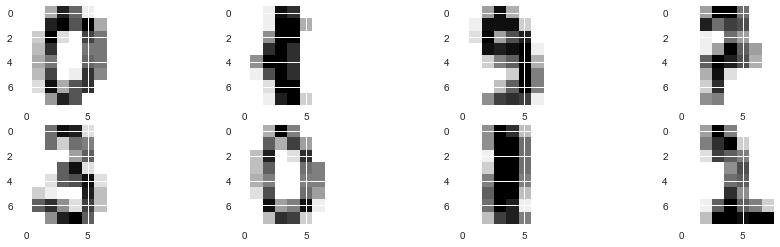

In [7]:
fig, ax = plt.subplots(2, 4)
fig.set_figheight(4)
fig.set_figwidth(15)

## Display the image of the rows 0, 100, 200 and 300 in the first row
for col, sample in zip(list(range(0,4)), list(range(0,500,100))):
    if sample==0:
        img = rDigits.iloc[sample].values
    else:
        img = rDigits.iloc[sample-1].values
    img_reshaped = img.reshape(8,8)
    ax[0, col].imshow(img_reshaped, cmap='gray_r')
    
for col, sample in zip(list(range(0,4)), list(range(1000,1400,100))):
    img = rDigits.iloc[sample-1].values
    img_reshaped = img.reshape(8,8)
    ax[1, col].imshow(img_reshaped, cmap='gray_r')

<hr>

<center><h2> Model Building </h2></center>

### KNN Classifier  - 4 Fold CV

- This instance base-learning algorithm makes no assumption about linearity between the features and the output label. Thus, it can capture nonlinearity in the data.
- We will test the performance of this algorithm in this section

Maximum accuracy: 0.9677233358079684


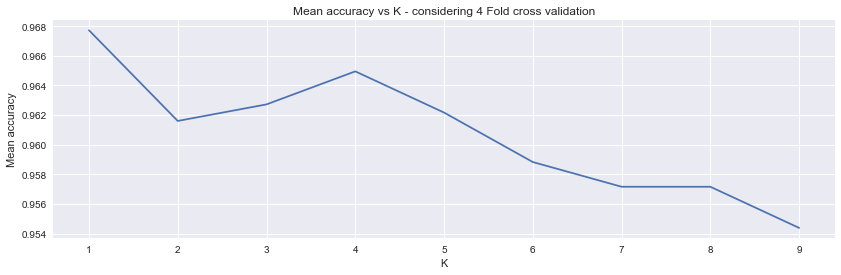

In [36]:
## Function to train the model
def KNN_train(neighbors, features_train, labels_train):
    # Instantiate the model
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(features_train, labels_train)
    return knn

## Function to test the model
def KNN_test(model, features_test, labels_test):
    predictions = model.predict(features_test)
    accuracy = accuracy_score(predictions, labels_test)
    return accuracy
    
## Cross-validation function
def crossvalidation(number_splits, data, labels, neighbors):
    list_of_accuracies = []
    kf = KFold(n_splits=number_splits, random_state=2)
    for train_index, test_index in kf.split(data):
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        knn = KNN_train(neighbors, X_train, y_train)
        accuracy = KNN_test(knn, X_test, y_test)
        list_of_accuracies.append(accuracy)
    return list_of_accuracies

## Call cross-validation function for different parameters
neighbors = list(range(1, 10))

k_overall_accuracies = []
for neigh in neighbors:
    accuracy = crossvalidation(number_splits=4, data=rDigits, labels=labels, neighbors=neigh)
    mean_accuracy = np.mean(accuracy)
    k_overall_accuracies.append(mean_accuracy)
print('Maximum accuracy:', max(k_overall_accuracies))
    
## Plot the results
plt.figure(figsize=(14,4))
plt.plot(neighbors, k_overall_accuracies)
plt.title('Mean accuracy vs K - considering 4 Fold cross validation')
plt.xlabel('K')
plt.ylabel('Mean accuracy')

KNN had a good mean accuracy but the algorithm has its down sides:
- high memory usage (for each new unseen observation, the algorithm calculates the euclidean distance between the new observation and every single point in the trainning set, rank the entire dataset by this euclidean distance in descending order and take into account the K first datapoints to predict the label of the unseen observation)
- it is an algorithm and not a model. Therefore, there is no representation to debug and explore

### Neural Network with One Hidden Layer - 4 Fold CV

Maximum accuracy: 0.9622222222222222


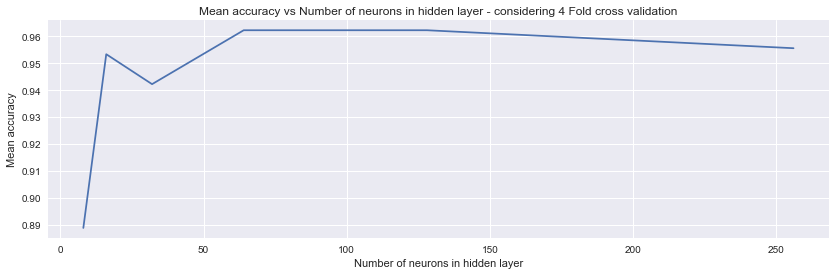

In [37]:
def crossvalidation_nn(n_folds, data, labels, neuron):
    ## Perform kfold cross-validation
    kf = KFold(n_splits=n_folds)
    list_of_accuracies=[]
    for train_index, test_index in kf.split(data):
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        ## Instantiate the model
        nn = MLPClassifier(hidden_layer_sizes=(neuron,), max_iter=1000)
        nn.fit(X_train, y_train)
        predictions = nn.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        list_of_accuracies.append(accuracy)
        return list_of_accuracies
        
list_of_neurons = [8, 16, 32, 64, 128, 256]
overall_accuracies = []
for neuron in list_of_neurons:
    accuracies = crossvalidation_nn(4, rDigits, labels, neuron)
    mean_accuracy = np.mean(accuracies)
    overall_accuracies.append(mean_accuracy)
print('Maximum accuracy:', max(overall_accuracies))
    
## Plot the results
plt.figure(figsize=(14,4))
plt.plot(list_of_neurons, overall_accuracies)
plt.title('Mean accuracy vs Number of neurons in hidden layer - considering 4 Fold cross validation')
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Mean accuracy')

**Conclusion**
- From the graph above, it is possible to conclude that adding more neurons in the hidden layer results in a better accuracy. However, we cannot conclude anything about false positives or true negatives since accuracy only computes the number of overall correct classifications the model made
- Comparing the best accuracy betweem the 2 models (KNN and NN), we can see that there's not much difference between the two (both of them results in an accuracy ~96%). Since Neural Networks are harder to understand (often called blackbox models), KNN is a better model to use compared to an NN with 1 hidden layer

### Neural Network with Two Hidden Layer - 4 Fold CV

Maximum accuracy: 0.9644444444444444
[0.9466666666666667, 0.9511111111111111, 0.9644444444444444]


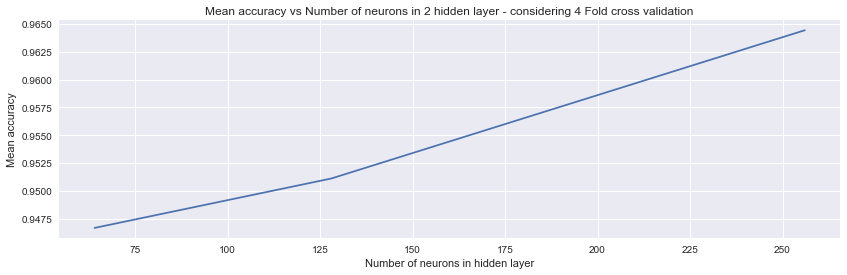

In [43]:
def crossvalidation_2nn(n_folds, data, labels, neuron1, neuron2):
    ## Perform kfold cross-validation
    kf = KFold(n_splits=n_folds)
    list_of_accuracies=[]
    for train_index, test_index in kf.split(data):
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        ## Instantiate the model
        nn = MLPClassifier(hidden_layer_sizes=(neuron1, neuron2), max_iter=1000)
        nn.fit(X_train, y_train)
        predictions = nn.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        list_of_accuracies.append(accuracy)
        return list_of_accuracies
        
list_of_neurons = [64, 128, 256]
overall_accuracies = []
for neuron in list_of_neurons:
    neuron1 = neuron
    neuron2 = neuron
    accuracies = crossvalidation_2nn(4, rDigits, labels, neuron1, neuron2)
    mean_accuracy = np.mean(accuracies)
    overall_accuracies.append(mean_accuracy)
print('Maximum accuracy:', max(overall_accuracies))
print(overall_accuracies)
    
## Plot the results
plt.figure(figsize=(14,4))
plt.plot(list_of_neurons, overall_accuracies)
plt.title('Mean accuracy vs Number of neurons in 2 hidden layer - considering 4 Fold cross validation')
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Mean accuracy')

**Conclusion**
- From the graph above, it is possible to conclude that adding one more layer to the model does not significantly improve our accuracy
- Since adding more hidden layers usually results in overfitting the model, the section below will run a 3 hidden layers neural network with 6 fold crossvalidation

### Neural Network with Three Hidden Layer - 6 Fold CV

Maximum accuracy: 0.9666666666666667
[0.9033333333333333, 0.93, 0.9666666666666667]


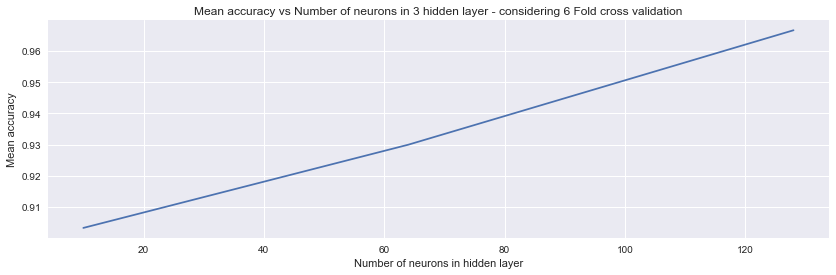

In [44]:
def crossvalidation_3nn(n_folds, data, labels, neuron1, neuron2, neuron3):
    ## Perform kfold cross-validation
    kf = KFold(n_splits=n_folds)
    list_of_accuracies=[]
    for train_index, test_index in kf.split(data):
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        ## Instantiate the model
        nn = MLPClassifier(hidden_layer_sizes=(neuron1, neuron2, neuron3), max_iter=1000)
        nn.fit(X_train, y_train)
        predictions = nn.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        list_of_accuracies.append(accuracy)
        return list_of_accuracies
        
list_of_neurons = [10, 64, 128]
overall_accuracies = []
for neuron in list_of_neurons:
    neuron1 = neuron
    neuron2 = neuron
    neuron3 = neuron
    accuracies = crossvalidation_3nn(6, rDigits, labels, neuron1, neuron2, neuron3)
    mean_accuracy = np.mean(accuracies)
    overall_accuracies.append(mean_accuracy)
print('Maximum accuracy:', max(overall_accuracies))
print(overall_accuracies)
    
## Plot the results
plt.figure(figsize=(14,4))
plt.plot(list_of_neurons, overall_accuracies)
plt.title('Mean accuracy vs Number of neurons in 3 hidden layer - considering 6 Fold cross validation')
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Mean accuracy')

**Conclusion**
- From the graph above, it is possible to conclude that adding one more layer to the model does not significantly improve our accuracy (less than 1% of improvement)
- Neural Network with 3 hidden layers have a great accuracy overall, even with a 6-fold crossvalidation
- It is possible to see that, for this dataset, adding more layers and more neurons tends to improve the model performance (if the error metric chosen is accuracy as well. For other error metrics, further analysis must be ran)

<hr>